### AIRQO Air Quality Prediction

Satellite-derived PM2.5 estimates based on Aerosol Optical Depth (AOD) and machine learning techniques can be used to estimate pollution levels over large areas to help develop interventions such as vulnerability risk profiles for urban spaces, health preservation and environmental protection for affected populations, as well as community empowerment, and climate change mitigation.

In this challenge, you are asked to estimate PM2.5 levels from satellite observations based on Aerosol Optical Depth (AOD) for eight cities in seven African countries - Lagos, Accra, Nairobi, Yaounde, Bujumbura, Kisumu, Kampala, and Gulu - with varying ground monitoring resolutions, using appropriate machine learning algorithms. Ground-based observations in the selected cities will be used to validate the satellite estimates.

In [31]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import shap
import warnings
from dataclasses import dataclass
from matplotlib import pyplot as plt

#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from sklearn.ensemble import RandomForestRegressor

pd.set_option("display.width", 100)
pd.set_option("display.max_columns", 70)
warnings.filterwarnings("ignore")

In [32]:
train_df = pd.read_csv("./data/Train.csv")
test_df = pd.read_csv("./data/Test.csv")
print(f"Train shape: {train_df.shape},  Test shape: {test_df.shape}")
train_df.head()

Train shape: (8071, 80),  Test shape: (2783, 79)


,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,...,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.756392,45185.49959,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
3,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-08,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.591543,828920.6875,-95.863083,65.508858,-122.218231,43.923038,0.118412,3.505708,0.416643,226.529633,1.000000,-95.863083,65.508858,-122.218231,43.923038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

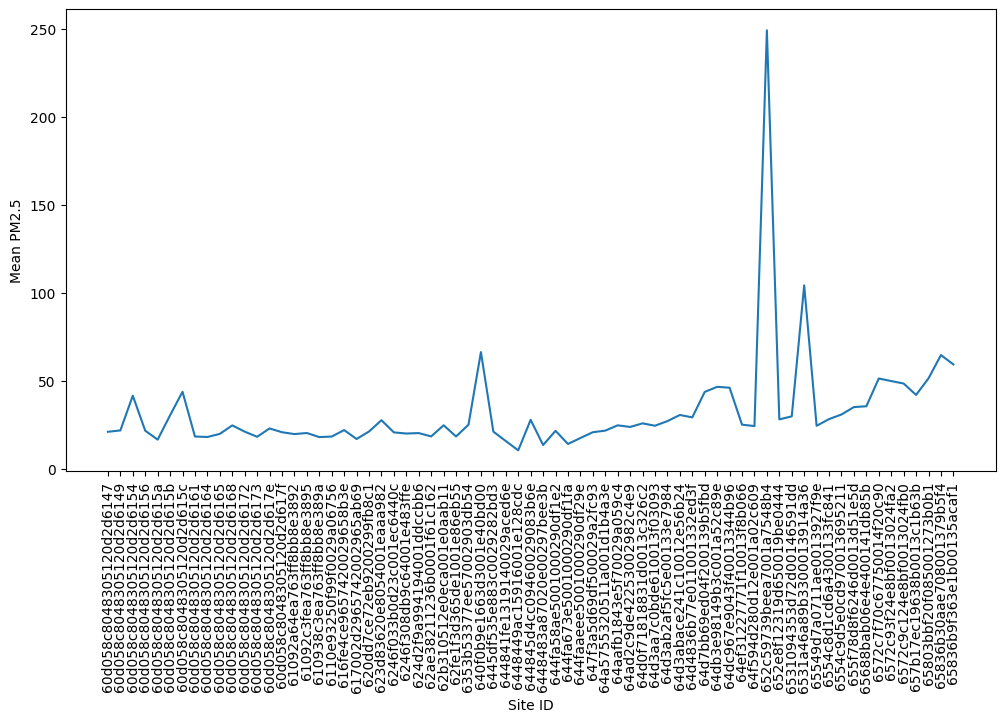

In [33]:
## pm2_5 trends by city
city_pm2_5 = train_df.groupby("site_id")["pm2_5"].mean().reset_index()
#city_pm2_5.plot();
plt.figure(figsize=(12, 6))
plt.plot(city_pm2_5["site_id"], city_pm2_5["pm2_5"])
plt.xticks(city_pm2_5["site_id"], city_pm2_5["site_id"], rotation=90)
plt.xlabel("Site ID")
plt.ylabel("Mean PM2.5")
plt.show()

In [34]:
# get site_id with highest avg. pm2_5
#print(city_pm2_5.loc[city_pm2_5["pm2_5"].idxmax()])
#train_df[train_df["site_id"] == city_pm2_5.loc[city_pm2_5["pm2_5"].idxmax()]["site_id"]].head()

In [35]:
# drop readings site_id 652c59739beea7001a7548b4
#train_df = train_df[train_df["site_id"] != city_pm2_5.loc[city_pm2_5["pm2_5"].idxmax()]["site_id"]]
#print(train_df.shape)

* Site ID `652c59739beea7001a7548b4` in `Lagos, Nigeria` has the highest/worst pollution relative to the other cities and city sites.

* Spectral Analysis (Sentinel-5P): The TROPOMI instrument measures the intensity of sunlight reflected by Earth at various wavelengths. Scientists then use this spectral information to identify the presence of specific gases like SO2.

* Algorithm Processing:  Advanced algorithms are applied to the spectral data to retrieve the quantity of interest, which in this case is the SO2 concentration. These algorithms take into account factors like:
  * Absorption properties of SO2 gas at different wavelengths
  * Atmospheric conditions like temperature and pressure
  * The instrument's characteristics and potential calibration factors

In [36]:
train_df.dtypes

id                             object
site_id                        object
site_latitude                 float64
site_longitude                float64
city                           object
                               ...   
cloud_sensor_azimuth_angle    float64
cloud_sensor_zenith_angle     float64
cloud_solar_azimuth_angle     float64
cloud_solar_zenith_angle      float64
pm2_5                         float64
Length: 80, dtype: object

In [37]:
train_df["city"].value_counts() 

city
Kampala      5596
Nairobi      1500
Lagos         852
Bujumbura     123
Name: count, dtype: int64

In [38]:
def check_missing_data(data: pd.DataFrame) -> pd.DataFrame:
  """Checks a given dataframe for missing values and types of the data features."""
  total = data.isna().sum()
  percent = (data.isna().sum()/data.isna().count()*100)
  tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  types = []
  for col in data.columns:
      dtype = str(data[col].dtype)
      types.append(dtype)
  tt['Types'] = types
  return(np.transpose(tt))

check_missing_data(train_df) 

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,...,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
Total,0,0,0,0,0,0,0,0,4912,4912,4912,4912,4912,4912,4912,4912,4912,0,3630,3630,3630,3630,3630,3630,3630,3630,4967,4967,4967,4967,4967,4967,4967,4967,4967,...,3915,5,5,5,5,5,5,112,112,112,112,112,112,112,112,112,7644,7644,7644,7644,7644,7644,7644,3077,3077,3077,3077,3077,3077,3077,3077,3077,3077,3077,0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.859869,60.859869,60.859869,60.859869,60.859869,60.859869,60.859869,60.859869,60.859869,0.0,44.975839,44.975839,44.975839,44.975839,44.975839,44.975839,44.975839,44.975839,61.541321,61.541321,61.541321,61.541321,61.541321,61.541321,61.541321,61.541321,61.541321,...,48.507,0.06195,0.06195,0.06195,0.06195,0.06195,0.06195,1.387684,1.387684,1.387684,1.387684,1.387684,1.387684,1.387684,1.387684,1.387684,94.709454,94.709454,94.709454,94.709454,94.709454,94.709454,94.709454,38.124148,38.124148,38.124148,38.124148,38.124148,38.124148,38.124148,38.124148,38.124148,38.124148,38.124148,0.0
Types,object,object,float64,float64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [39]:
check_missing_data(test_df) 

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,...,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
Total,0,0,0,0,0,0,0,0,1074,1074,1074,1074,1074,1074,1074,1074,1074,0,1031,1031,1031,1031,1031,1031,1031,1031,1094,1094,1094,1094,1094,1094,1094,1094,1094,...,760,760,1,1,1,1,1,1,14,14,14,14,14,14,14,14,14,2719,2719,2719,2719,2719,2719,2719,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279,1279
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.591448,38.591448,38.591448,38.591448,38.591448,38.591448,38.591448,38.591448,38.591448,0.0,37.046353,37.046353,37.046353,37.046353,37.046353,37.046353,37.046353,37.046353,39.310097,39.310097,39.310097,39.310097,39.310097,39.310097,39.310097,39.310097,39.310097,...,27.30866,27.30866,0.035932,0.035932,0.035932,0.035932,0.035932,0.035932,0.503054,0.503054,0.503054,0.503054,0.503054,0.503054,0.503054,0.503054,0.503054,97.700323,97.700323,97.700323,97.700323,97.700323,97.700323,97.700323,45.9576,45.9576,45.9576,45.9576,45.9576,45.9576,45.9576,45.9576,45.9576,45.9576,45.9576
Types,object,object,float64,float64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


* (UV) Aerosol (solar) features have highest percentage of missing data with ~94.7% missing yet PM_2.5 is derived largely based on aerosol data points (optical depth).

In [40]:
train_df.describe()

,site_latitude,site_longitude,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,...,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
count,8071.000000,8071.000000,8071.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,3159.000000,8071.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,4441.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,3104.000000,4156.000000,4156.000000,...,4156.000000,8066.000000,8066.000000,8066.000000,8066.000000,8066.000000,8066.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,7959.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,8071.000000
mean,0.635678,30.246982,10.877463,0.000024,0.687295,0.000013,0.126581,2.120939,38.671939,-92.912582,27.700157,0.000004,6.122414,0.034887,2200.218221,2041.463881,829573.191993,-8.063021,38.482742,-91.507702,28.609344,0.000074,0.000040,0.000033,0.000130,8836.367723,-0.369219,0.081754,829581.679425,-12.334603,37.299477,-93.711870,28.807872,0.000175,1.046935,...,-2.760999,-0.442617,829596.648655,-12.608537,41.387619,-88.902996,28.385504,0.117739,2.650292,0.316414,228.241939,0.516471,-13.304661,41.293259,-88.650645,28.541850,2217.913597,78611.503814,1.880600,32.951949,-25.433032,-81.188343,29.183047,0.580149,51850.474269,6089.449805,58478.947647,5105.978072,16.885186,0.255501,-18.952179,45.881380,-84.811978,28.708028,24.639296
std,2.154605,9.393151,0.815875,0.000354,0.142544,0.000220,0.094129,85.450554,18.964322,43.240479,

* Negative values for `cloud_solar_azimuth_angle` aren't valid azimuth angles. Azimuth angles are designed to range from `0 to 360 degrees`, indicating the horizontal direction of the sun relative to your observation point. Negative values fall outside this expected range.

* `Solar Zenith Angles`:	Angles between the sun and point of observation (sun directly overhead/zenith implies `0 degrees` or sun on horizon `90 degress`). Range from `0 to 90 deg`
  * Experiment with flipping signs to be sure if it was the measured angles or it was misplaced sign errors or add 360 to the negative angles if the angles are read & recorded in an anti-clowckwise manner.

* `uvaerosollayerheight_*` features have too many missing values

In [41]:
# Create datetime column
train_df["datetime"] = pd.to_datetime(train_df["date"] + " " + train_df["hour"].astype(str), format="%Y-%m-%d %H", dayfirst=True)
test_df["datetime"] = pd.to_datetime(test_df["date"] + " " + test_df["hour"].astype(str), format="%Y-%m-%d %H", dayfirst=True)

train_df = train_df.set_index("datetime")
test_df = test_df.set_index("datetime")

# create period features 0-morning, 1-afternoon
train_df["period"] = np.nan
test_df["period"] = np.nan

train_df.loc[(train_df["hour"] < 12), "period"] = 0
train_df.loc[(train_df["hour"] >= 12), "period"] = 1

test_df.loc[test_df["hour"] < 12, "period"] = 0
test_df.loc[(test_df["hour"] >= 12), "period"] = 1 

# sort data by date
train_df.sort_index()

# add week feature
train_df["week"] = train_df.index.isocalendar().week
test_df["week"] = test_df.index.isocalendar().week
train_df["year"] = train_df.index.isocalendar().year
test_df["year"] = test_df.index.isocalendar().year
train_df["day"] = train_df.index.isocalendar().day
test_df["day"] = test_df.index.isocalendar().day
train_df["week"] = train_df["week"].astype("int32")
test_df["week"] = test_df["week"].astype("int32")
train_df["day"] = train_df["day"].astype("int32")
test_df["day"] = test_df["day"].astype("int32")

encoder = LabelEncoder()
train_df["year"] = encoder.fit_transform(train_df["year"])
test_df["year"] = encoder.transform(test_df["year"])

# Drop date and hour columns columns
train_df = train_df.drop(["date", "hour", "month"], axis=1)
test_df = test_df.drop(["date", "hour", "month"], axis=1)

train_df.head()

,id,site_id,site_latitude,site_longitude,city,country,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,...,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,period,week,year,day
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-25 13:00:00,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000,1.0,43,1,3
2023-11-02 12:00:00,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200,1.0,44,1,4
2023-11-03 13:00:00,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.756392,45185.49959,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741,1.0,44,1,5
2023-11-08 14:00:00,id_9aandqzy4n,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,65.508858,-122.218231,43.923038,0.118412,3.505708,0.416643,226.529633,1.000000,-95.863083,65.508858,-122.218231,43.923038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [42]:
# drop uvaerosollayerheight_* features as they have >90% missing values
uvaerosol_layerh_cols = [col for col in train_df.columns if col.startswith("uvaerosollayerheight_")]
train_df = train_df.drop(uvaerosol_layerh_cols, axis=1)
test_df = test_df.drop(uvaerosol_layerh_cols, axis=1)

## drop location info. since test is in unseen locations, won't rely on location info for the sake of generalization beyond train location
location_cols = ["country", "city", "site_id"]
train_df = train_df.drop(location_cols, axis=1)
test_df = test_df.drop(location_cols, axis=1)


print(f"train shape: {train_df.shape}  test shape: {test_df.shape}")

train shape: (8071, 71)  test shape: (2783, 70)


In [43]:
## Explore angular features
## zenith and azimuth angles should be within expected bounds (0-90 & 0-360 respectively)
zenith_cols = [col for col in train_df.columns if col.endswith("zenith_angle")]
azimuth_cols = [col for col in train_df.columns if col.endswith("azimuth_angle")]
angular_cols = zenith_cols + azimuth_cols
#train_df[angular_cols].describe()

## drop azimuth angle features for baseline model
train_df = train_df.drop(angular_cols, axis=1)
test_df = test_df.drop(angular_cols, axis=1)
print(f"train shape: {train_df.shape}  test shape: {test_df.shape}")

train shape: (8071, 43)  test shape: (2783, 42)


In [45]:
train_df.columns.tolist()[3:-5]

['sulphurdioxide_so2_column_number_density',
 'sulphurdioxide_so2_column_number_density_amf',
 'sulphurdioxide_so2_slant_column_number_density',
 'sulphurdioxide_cloud_fraction',
 'sulphurdioxide_so2_column_number_density_15km',
 'carbonmonoxide_co_column_number_density',
 'carbonmonoxide_h2o_column_number_density',
 'carbonmonoxide_cloud_height',
 'carbonmonoxide_sensor_altitude',
 'nitrogendioxide_no2_column_number_density',
 'nitrogendioxide_tropospheric_no2_column_number_density',
 'nitrogendioxide_stratospheric_no2_column_number_density',
 'nitrogendioxide_no2_slant_column_number_density',
 'nitrogendioxide_tropopause_pressure',
 'nitrogendioxide_absorbing_aerosol_index',
 'nitrogendioxide_cloud_fraction',
 'nitrogendioxide_sensor_altitude',
 'formaldehyde_tropospheric_hcho_column_number_density',
 'formaldehyde_tropospheric_hcho_column_number_density_amf',
 'formaldehyde_hcho_slant_column_number_density',
 'formaldehyde_cloud_fraction',
 'uvaerosolindex_absorbing_aerosol_index',


In [46]:
## Impute missing values
train_df = train_df.interpolate(method="time")
test_df = test_df.interpolate(method="time")

# drop NaN values at the edges (start/end)
train_df = train_df.dropna()
test_df = test_df.dropna()

# Normalize features
p_features = train_df.columns.tolist()[3:-5]
weeks = train_df["week"].unique().tolist()
# Ensure the index is a datetime index
#train_df = train_df.set_index(pd.DatetimeIndex(train_df.index))
#test_df = test_df.set_index(pd.DatetimeIndex(test_df.index))

for pf in p_features:
  # weeks = train_df["week"].unique().tolist()
  #  test_weeks = test_df["week"].unique().tolist()
  #  for w in weeks:
  #      week_data = train_df[train_df["week"] == w][pf]
  #      scaler = StandardScaler()
  #      train_df.loc[train_df['week'] == w, pf] = scaler.fit_transform(week_data.values.reshape(-1, 1)).squeeze()
  #      if w in set(test_weeks):
  #        test_week_data = test_df[test_df["week"] == w][pf]
  #        test_df.loc[test_df["week"] == w, pf] = scaler.transform(test_week_data.values.reshape(-1, 1)).squeeze()
  scaler = StandardScaler()
  train_df[pf] = scaler.fit_transform(train_df[pf].values.reshape(-1, 1))
  test_df[pf] = scaler.transform(test_df[pf].values.reshape(-1, 1))

train_df.describe()

,site_latitude,site_longitude,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_so2_column_number_density_15km,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,pm2_5,period,week,year,day
count,8067.000000,8067.000000,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8.067000e+03,8067.000000,8067.000000,8067.000000,8067.000000,8067.000000
mean,0.632754,30.260294,6.165612e-18,2.395781e-16,-1.145042e-17,6.517933e-17,-9.248418e-18,-4.932490e-16,2.924262e-16,1.937764e-16,2.213596e-13,-2.686445e-16,2.668829e-16,-9.970675e-16,9.864979e-17,1.825902e-15,6.517933e-17,-1.056962e-17,1.561926e-14,-4.404009e-17,-2.113924e-17,1.937764e-17,-3.347046e-17,-5.460971e-17,-1.022910e-13,-2.607173e-16,-8.825633e-16,-6.059916e-16,-5.781582e-15,1.083386e-16,9.732859e-17,4.932490e-16,-3.523207e-16,2.043460e-16,1.479747e-16,-2.730485e-17,2.994726e-16,24.638588,0.149002,24.654518,1.095575,4.100533
std,2.151132,9.376428,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,1.000062e+00,24.882875,0.356113,14.699908,0.299870,1.892062
min,-3.459970,3.201510,-3.105015e+00,-2.682853e+00,-3.567099e+00,-1.681249e+00,-3.513553e+00,-1.627372e+00,-1.617744e+00,-1.552298e+00,-3.283577e+00,-2.632407e+00,-2.752709e+00,-3.200664e+00,-2.247112e+00,-1.704377e+00,-2.693178e+00,-1.440986e+00,-3.146661e+00,-3.502157e+00,-2.414385e+00,-3.788693e+00,-1.597302e+00,-2.993313e+00,-2.969620e+00,-3.191236e+00,-1.524760e+00,-1.900362e+00,-5.110025e+00,-1.409904e+00,-1.674637e+00,-2.559277e+00,-1.915677e+00,-2.609963e+00,-1.768774e+00,-5.995965e-01,-3.566631e+00,1.200000,0.000000,1.000000,0.000000,1.000000
25%,0.288630,32.568643,-6.078535e-01,-6.780940e-01,-6.294663e-01,-7.693526e-01,-6.642576e-01,-6.757227e-01,-6.702301e-01,-8.143565e-01,-6.135080e-01,-5.517552e-01,-5.408538e-01,-7.757215e-01,-6.159043e-01,-3.218671e-01,-6.137703e-01,-7.115447e-01,-5.949899e-01,-5.390314e-01,-6.439651e-01,-6.031524e-01,-8.952020e-01,-7.100331e-01,-6.897551e-01,-4.301483e-01,-8.856030e-01,-8.543644e-01,-6.119383e-01,-9.295078e-01,-9.420473e-01,-7.875853e-01,-7.702932e-01,-7.816244e-01,-7.748899e-01,-4.159679e-01,-5.833650e

In [47]:
# create location clusters
k = 4
kmeans_features = ["site_latitude", "site_longitude"]
location_features = train_df[kmeans_features].values
kmeans = KMeans(n_clusters=k, random_state=42, algorithm="lloyd") #"lloyd"
kmeans.fit(location_features)

# Add cluster label as a new feature
assert kmeans.labels_.all() == kmeans.predict(train_df[kmeans_features].values).all(), "Mismatch in cluster labels"
train_df["location_cluster"] = kmeans.labels_
test_df["location_cluster"] = kmeans.predict(test_df[kmeans_features].values)

In [48]:
train_df = train_df.drop(["site_latitude", "site_longitude"], axis=1)
test_df = test_df.drop(["site_latitude", "site_longitude"], axis=1)
test_df["location_cluster"].value_counts()

location_cluster
0    2322
1     461
Name: count, dtype: int64

In [49]:
# Filter large pm2_5 features
train_df = train_df[train_df["pm2_5"] < 150] #100>>150,
print(train_df.shape)

(8021, 42)


* Variable performance at number of columns dropped vs pm2_5 threshold. Currently pm2_5 < 150 performs better than pm2_5 < 100 when highly correlated features `hc_cols = [
  "cloud_cloud_top_pressure", "cloud_cloud_fraction", "sulphurdioxide_so2_column_number_density_15km", "nitrogendioxide_stratospheric_no2_column_number_density"
]` are dropped but pm2_5 < 100 performs better when only `cloud_cloud_top_pressure` is dropped. The model params and 8fold tssplit remaining constant throughout.

In [50]:
# drop sensor altitude data
# Sensor metadata may be just noise. Dropping height features also improves model RMSE.
sensor_alt_cols = [col for col in train_df.columns if col.endswith("sensor_altitude")] +\
  [col for col in train_df.columns if col.endswith("height")]
print(len(sensor_alt_cols))

train_df = train_df.drop(sensor_alt_cols, axis=1)
test_df = test_df.drop(sensor_alt_cols, axis=1)
print(train_df.shape, test_df.shape)

6
(8021, 36) (2783, 35)


In [51]:
corr_matrix = train_df.select_dtypes(include=[float, int]).corr()
corr_matrix = corr_matrix.drop(["pm2_5"], axis=0).drop(["pm2_5"], axis=1)
threshold = 0.9
corr_abs = corr_matrix.abs()
correlated_cols = [col for col in corr_abs.columns 
                  for other_col in corr_abs.columns[corr_abs.index > col] 
                  if corr_abs.loc[col, other_col] > threshold and col != other_col]

# Drop correlated features (excluding the target column if provided)
train_df = train_df.drop(correlated_cols, axis=1)
test_df = test_df.drop(correlated_cols, axis=1)
train_df.shape

(8021, 30)

In [52]:
#train_df.to_csv("train_clean.csv", index=False)

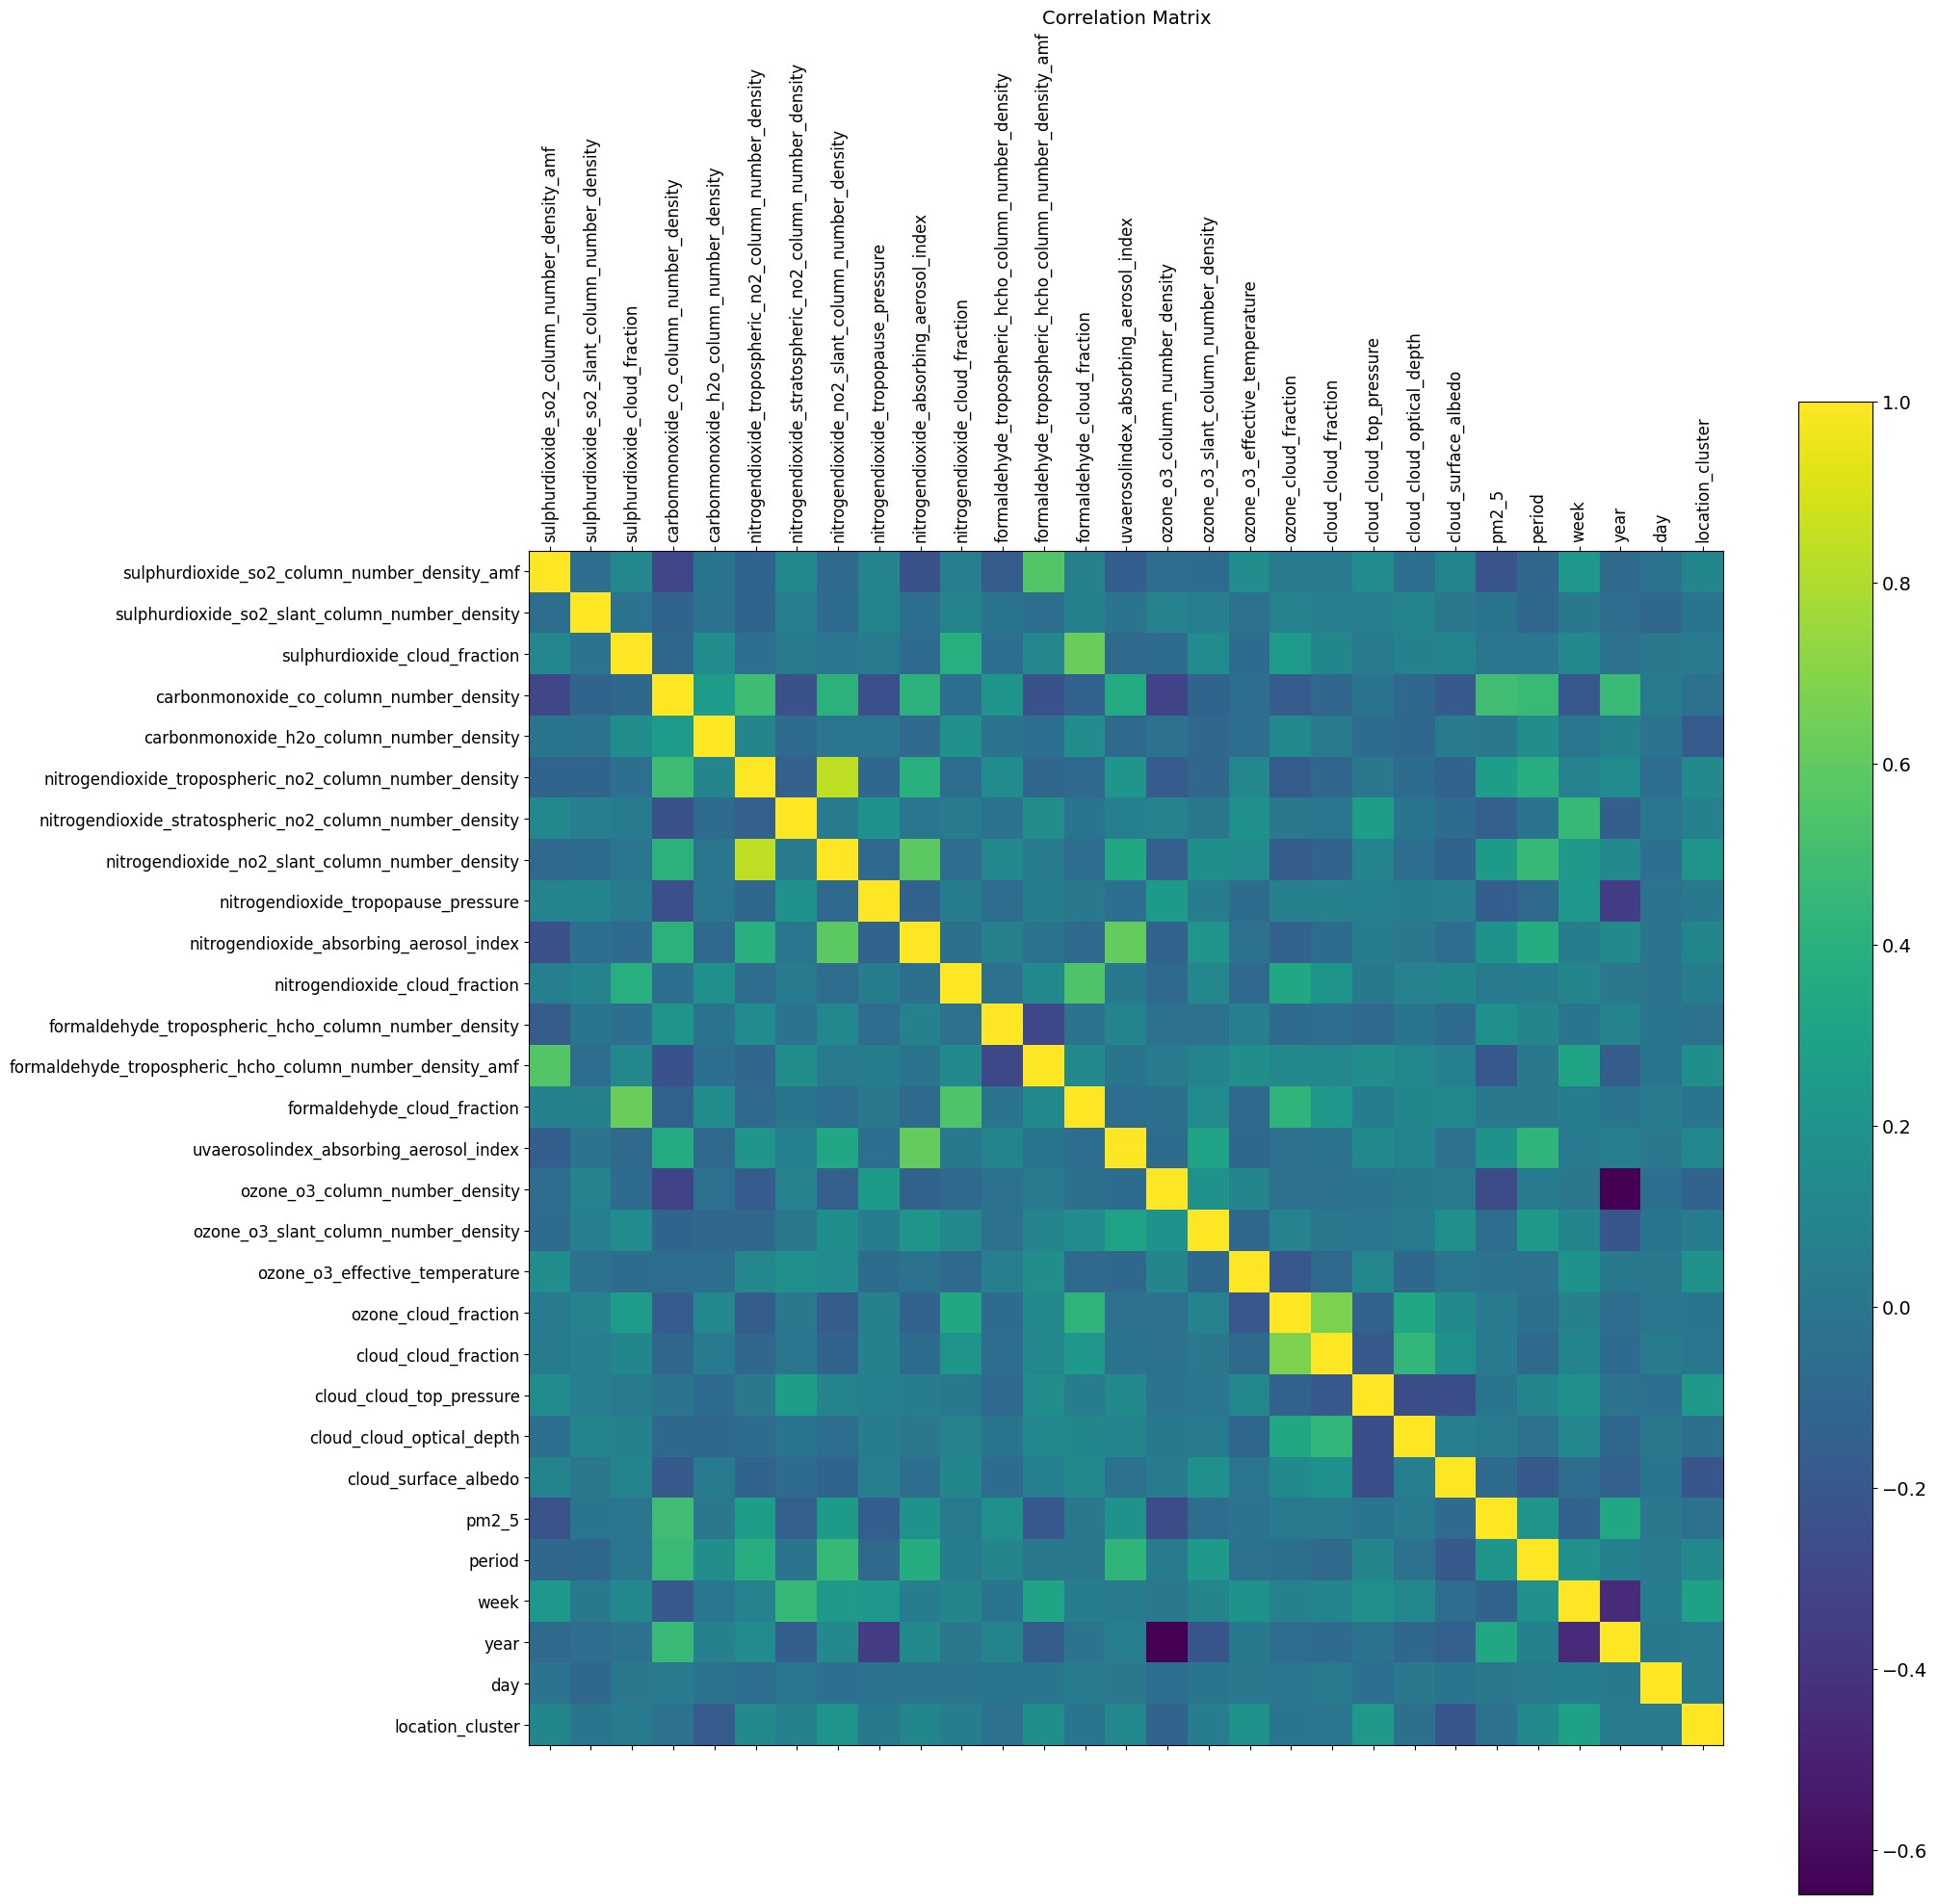

In [53]:
#correlations = train_df.select_dtypes(include=[float, int]).corr()
#sns.heatmap(correlations)
fig = plt.figure(figsize=(20, 20))
plt.matshow(train_df.select_dtypes(include=[float, int]).corr(), fignum=fig.number)
plt.xticks(range(train_df.select_dtypes(include=[float, int]).shape[1]), train_df.select_dtypes(include=[float, int]).columns, fontsize=12, rotation=90)
plt.yticks(range(train_df.select_dtypes(include=[float, int]).shape[1]), train_df.select_dtypes(include=[float, int]).columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Correlation Matrix", fontsize=14);

* `cloud_cloud_top_pressure` & `cloud_cloud_base_pressure` strong correlated but zero correlation to `cloud_cloud_top_height` & `cloud_cloud_base_height` which are also strongly correlated to each other

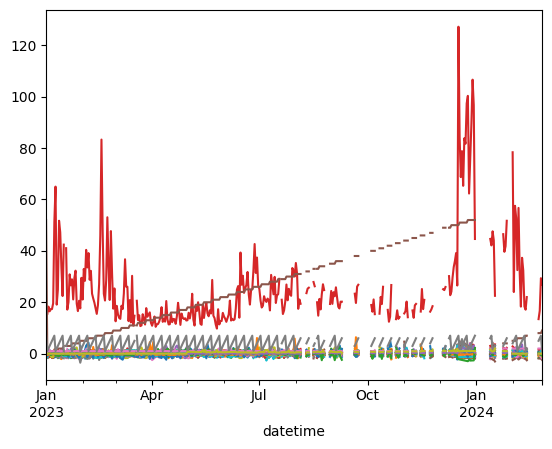

In [54]:
weekly = train_df.drop(["id"], axis=1).resample("D").mean()
weekly.plot(legend=False); #legend=False

* Hourly, daily & weekly plots yield a non-continuous timeseries showing that the data is recorded periodically hence no readings for some hours in a day.
* The monthly plot yields a continuous timeseries
* The large values above 800k are sensor altitudes

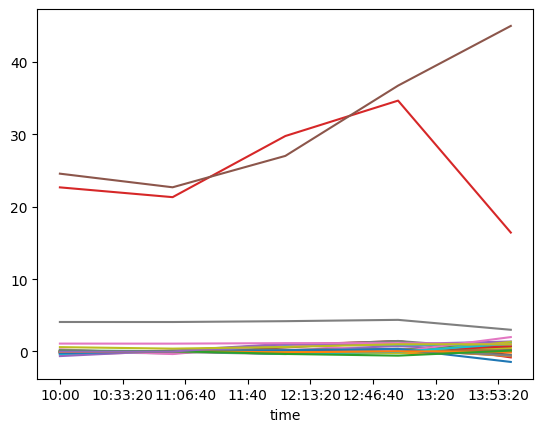

In [55]:
## Daily trends
by_time = train_df.drop(["id"], axis=1).groupby(train_df.index.time).mean()
#hourly_ticks = 5 * 60 * 60 * np.arange(5)
by_time.plot(legend=False); 

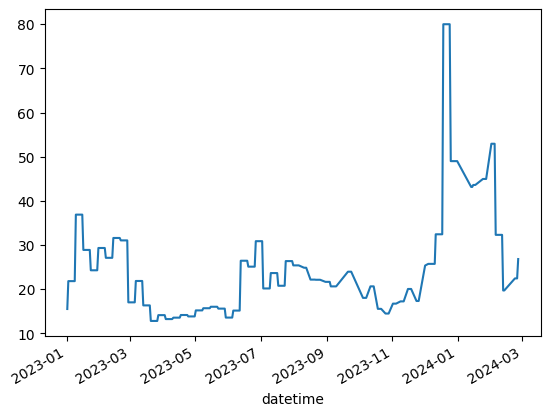

In [56]:
## Weekly pm2_5 trends
by_time = train_df.groupby(pd.Grouper(freq="W"))["pm2_5"].transform("mean")
by_time.plot();

In [57]:
min(train_df.index.time), max(train_df.index.time), min(test_df.index.time), max(test_df.index.time)

(datetime.time(10, 0),
 datetime.time(14, 0),
 datetime.time(10, 0),
 datetime.time(14, 0))

In [58]:
min(train_df.index), max(train_df.index), min(test_df.index), max(test_df.index)

(Timestamp('2023-01-01 11:00:00'),
 Timestamp('2024-02-26 11:00:00'),
 Timestamp('2023-05-01 11:00:00'),
 Timestamp('2024-02-24 11:00:00'))

* Air pollutant readings are recorded between 10am and 2pm

In [59]:
def RMSE(y_pred, true_value):
	"""Computes the root mean squared error."""
	return np.sqrt(mean_squared_error(y_pred, true_value))

In [60]:
def plot_and_evaluate(y_test, y_pred, time_index):
  """
  Plots predicted vs actual values and daily error, and calculates error metrics.
  
  Parameters:
  - y_test: True values
  - y_pred: Predicted values
  - time_index: Datetime index associated with y_test and y_pred
  
  Returns:
  - Prints MAE, MSE, MRE, STD_RE, and SCC.
  """
  # Calculate the error
  error = y_test - y_pred

  # Convert error to a pandas Series
  error_series = pd.Series(error, index=time_index)

  # Aggregate error by day
  daily_error = error_series.resample('D').mean()

  # Plotting the results and error as a function of time
  fig, axs = plt.subplots(1, 2, figsize=(16, 6))

  # First subplot: True vs Predicted values
  axs[0].scatter(y_test, y_pred, alpha=0.5, edgecolor="k", c="g")
  axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
  axs[0].set_xlabel('True Values')
  axs[0].set_ylabel('Predicted Values')
  axs[0].set_title('Predicted vs Actual Values', fontsize=20)

  # Second subplot: Error as a function of time
  axs[1].plot(daily_error.index, daily_error, marker='o', linestyle='')
  axs[1].axhline(y=0, color='k', linestyle='--')
  axs[1].set_xlabel('Time')
  axs[1].set_ylabel('Daily Average Error (True - Predicted)')
  axs[1].set_title('Error as a Function of Time', fontsize=20)

  plt.tight_layout()
  plt.show()

  # Calculate Errors and Correlation
  mae = mean_absolute_error(y_test, y_pred)
  rmse = RMSE(y_test, y_pred)

  # Display the metrics
  #print(f"Mean Squared Error (RMSE): {rmse}")
  #print(f"Mean Absolute Error (MAE): {mae}")
    

Fold 1 RMSE: 18.3390145772759


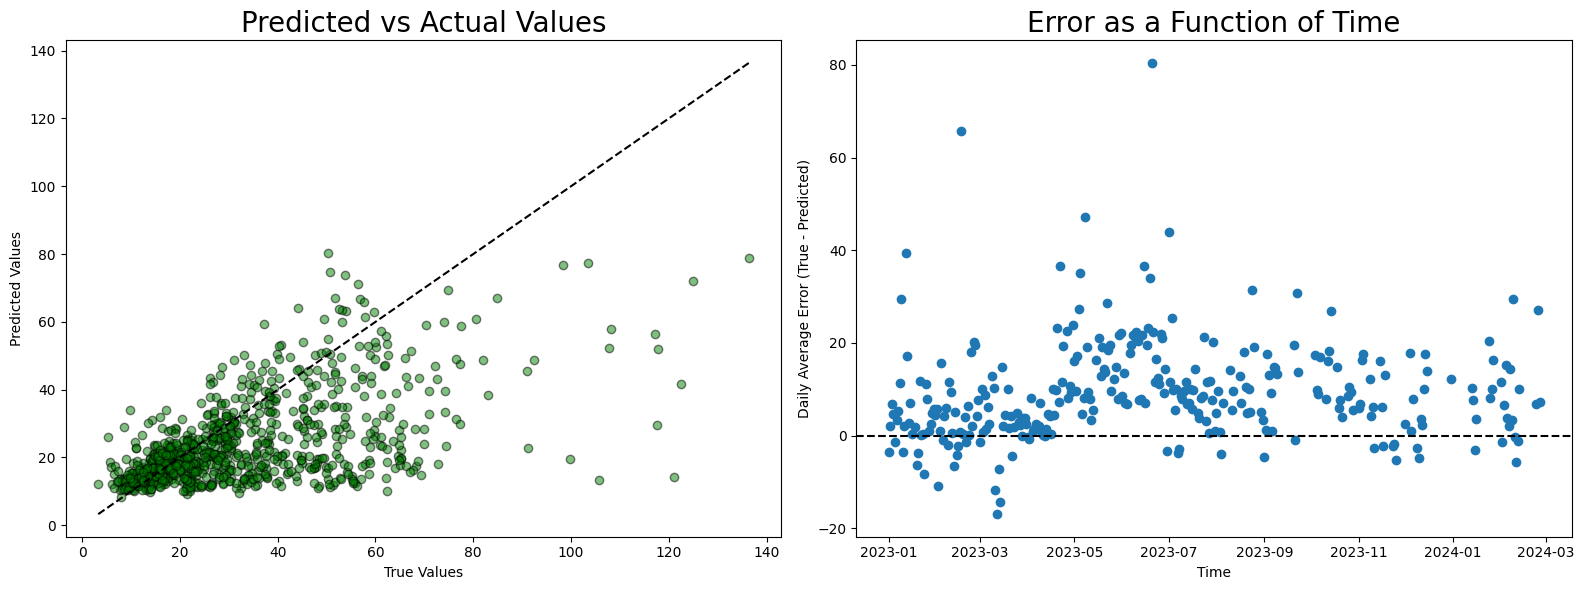

Fold 2 RMSE: 11.83211124990426


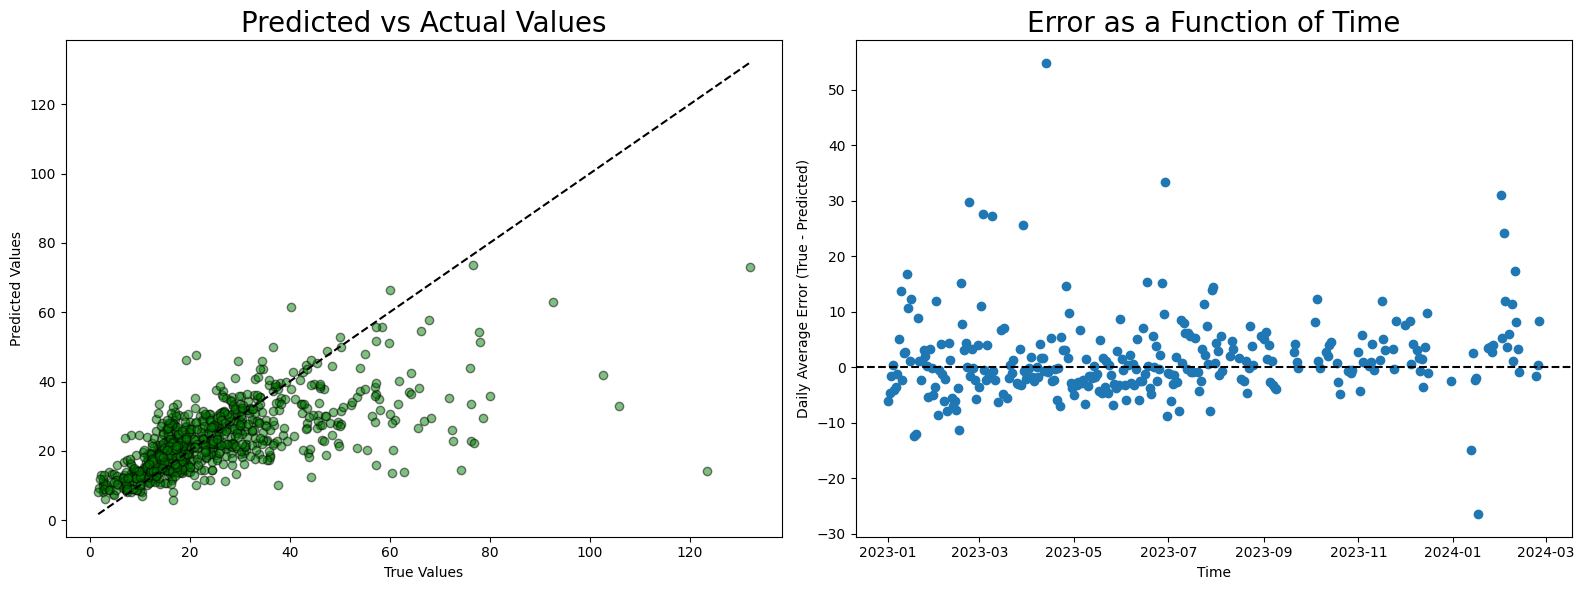

Fold 3 RMSE: 12.933332035760525


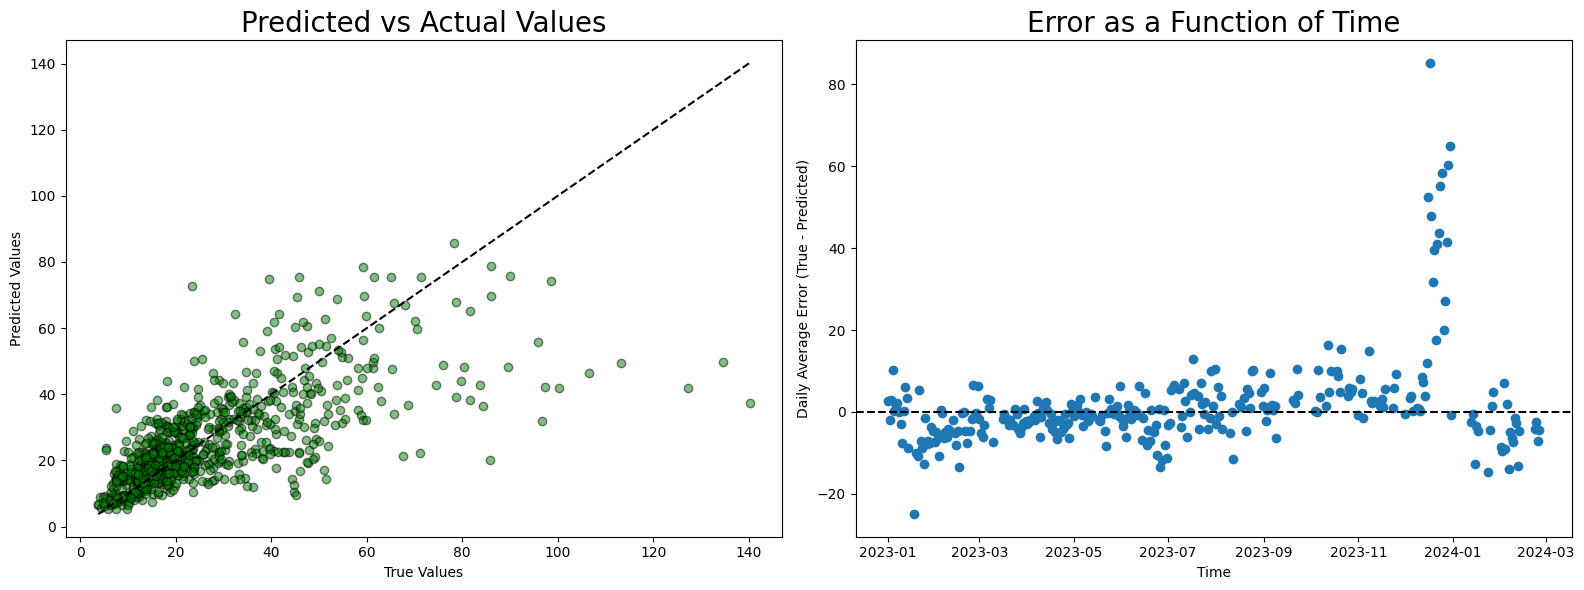

Fold 4 RMSE: 10.815389363292669


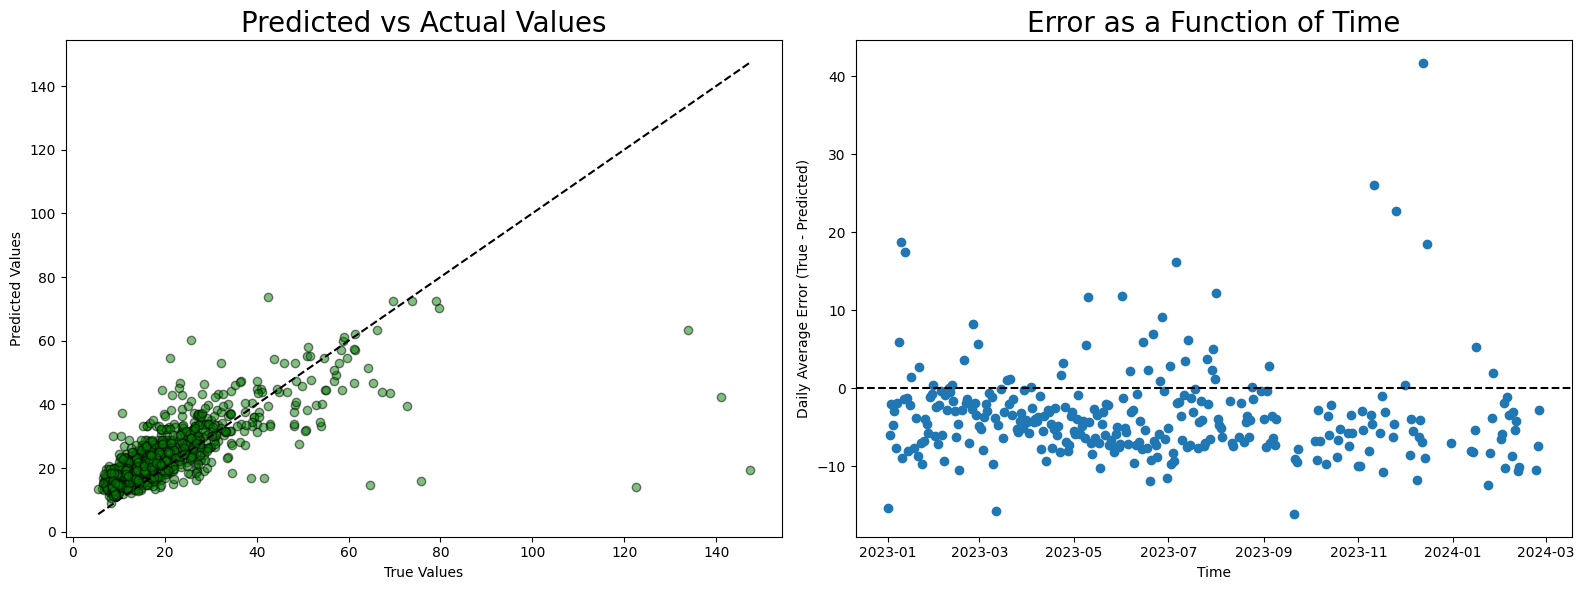

Fold 5 RMSE: 7.435585388253668


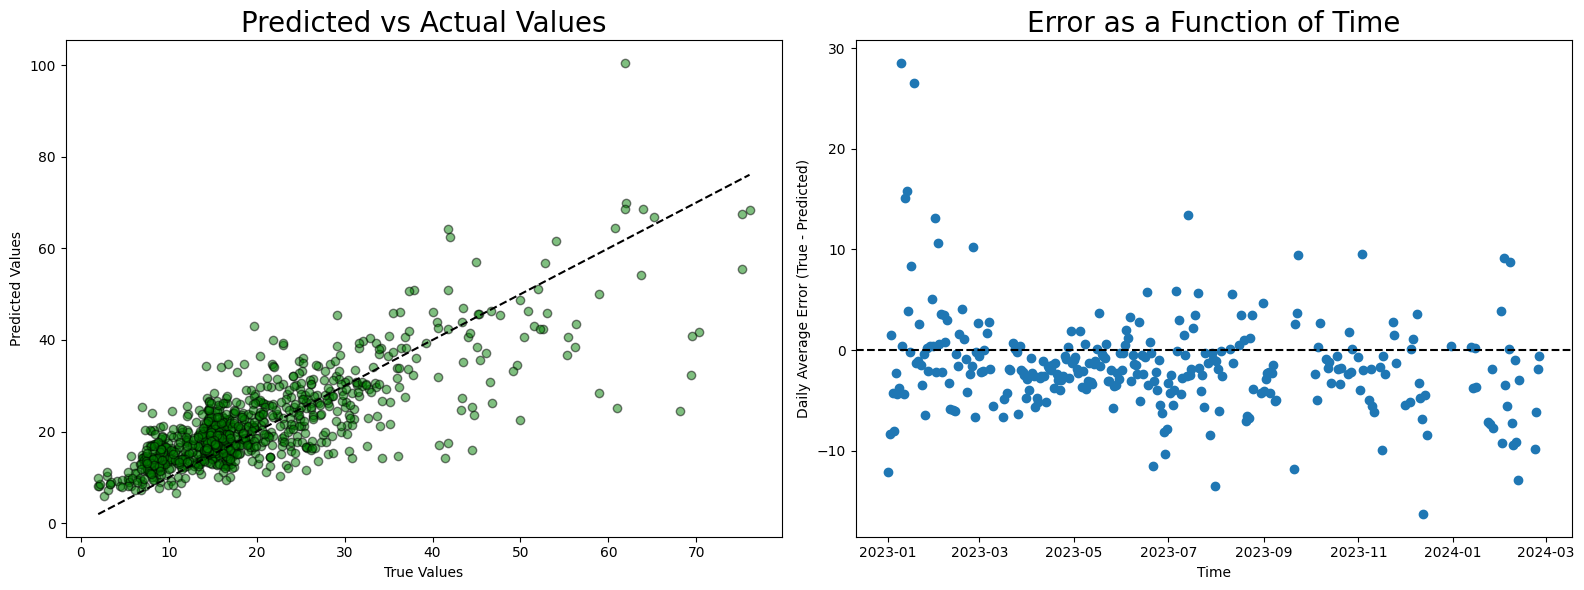

Fold 6 RMSE: 10.122458014739607


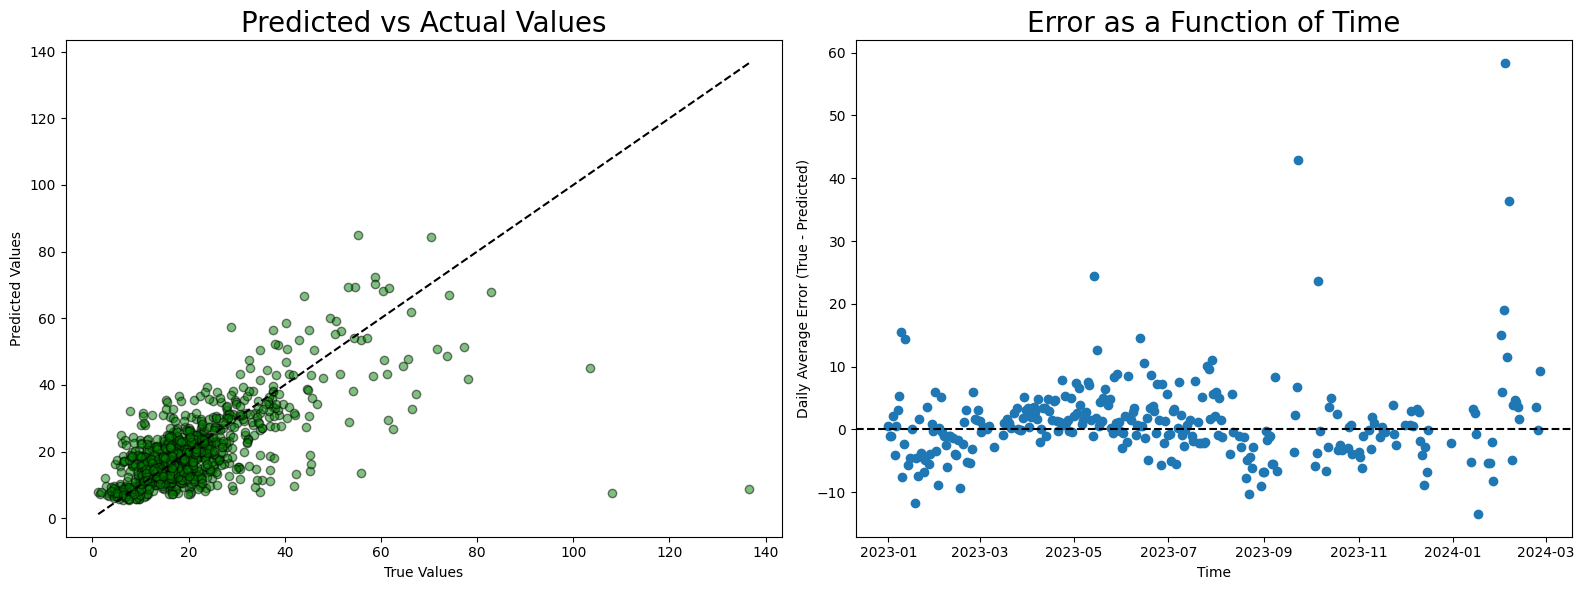

Fold 7 RMSE: 10.081712246675735


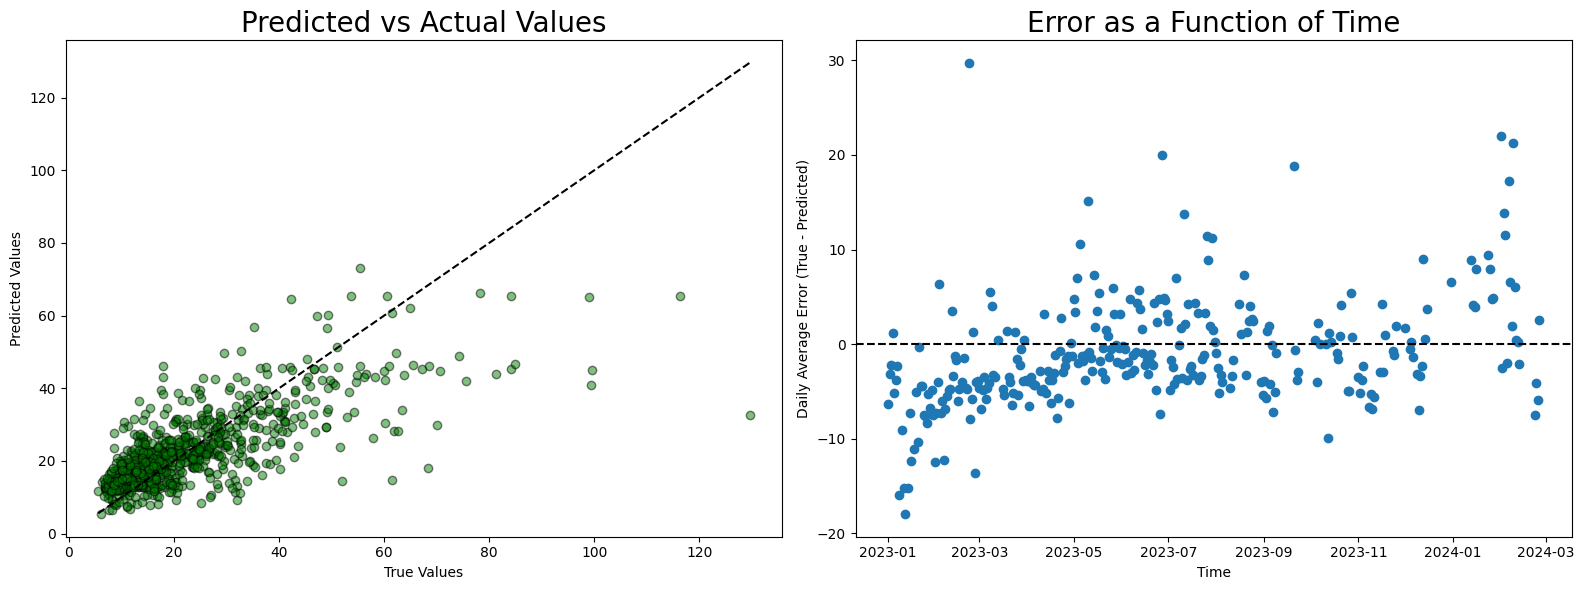

Fold 8 RMSE: 11.433473579498797


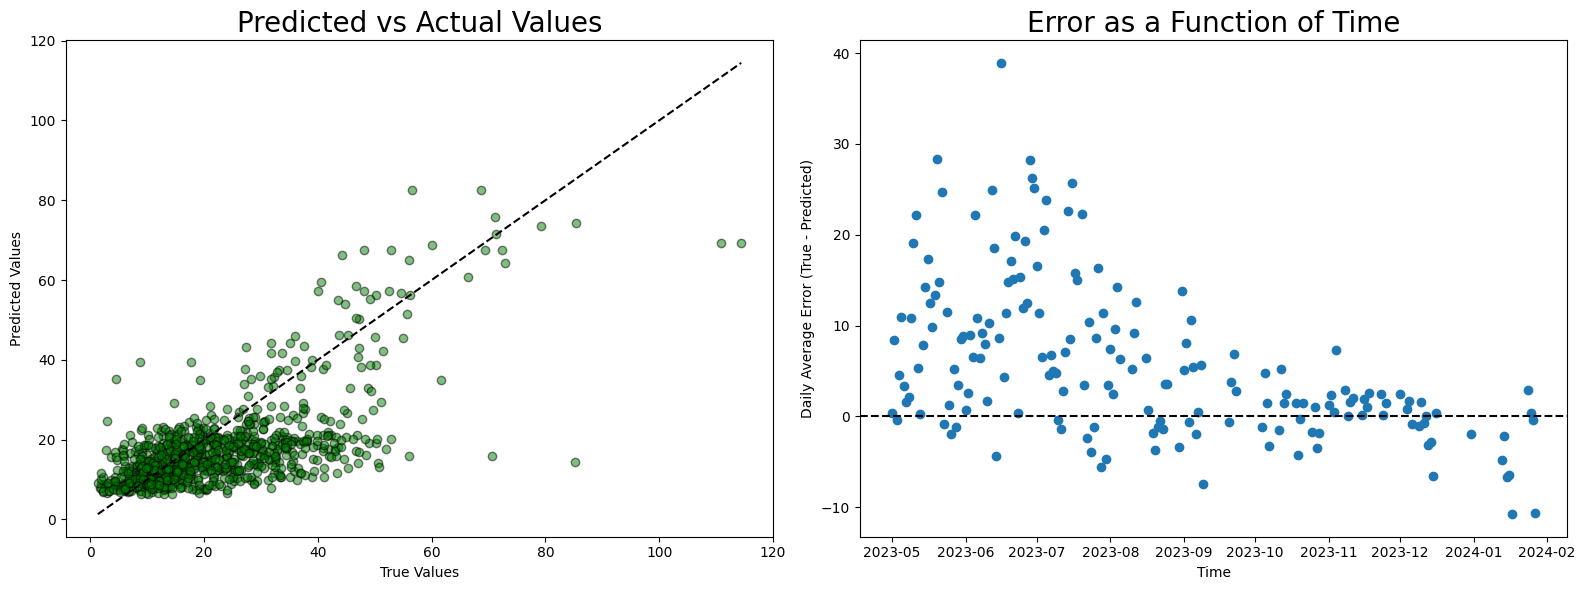

Average RMSE over 8 folds: 11.624134556925146


In [99]:
drop_cols = ["id", "pm2_5", "day"]
ids = test_df["id"]
X_test = test_df.drop(["id", "day"], axis=1)
target = train_df["pm2_5"]
features = train_df.drop(drop_cols, axis=1)
#cat_cols = ["week", "location_cluster", "period"]
#for c in cat_cols:
#    features[c] = features[c].astype(object)
# Initialize a DataFrame to store R-squared values
#r2_scores = pd.DataFrame(index=target, columns=features)

# Manual data split
# Split the dataset into training and validation sets for the current target
#train_period = "400D"  # 400 days train, 21 days validation (421 days total in train dataset)
# Find the date to split the data
#split_date = train_df.index.min() + pd.Timedelta(train_period)

#X_train = train_df.loc[train_df.index <= split_date, features]
#y_train = train_df.loc[train_df.index <= split_date, target[0]]
#X_val = train_df.loc[train_df.index > split_date, features]
#y_val = train_df.loc[train_df.index > split_date, target[0]]
#print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")


#xgb_model.fit(X_train, np.log1p(y_train))
#y_pred = xgb_model.predict(X_val)
tssplit = TimeSeriesSplit(n_splits=8)
#groups = train_df["location_cluster"]
#gkfsplit = GroupKFold(n_splits=12)
scores = []
test_predictions = []
#for lcluster in train_df["location_cluster"].unique():
#    lc_features = train_df[train_df["location_cluster"] == lcluster].sort_index()

for f, (train_idx, val_idx) in enumerate(tssplit.split(features, target), 1): #, groups)
    xgb_model = xgb.XGBRegressor(
        n_estimators=150,
        max_depth=3,
        max_leaves=15,
        eval_metric="rmse",
        booster="gbtree",
        objective="reg:squarederror",
        colsample_bytree=0.9,
        subsample=0.9,
        reg_alpha=1.5,
        #reg_lambda=1.5,
        learning_rate=0.143,
        random_state=42
    )
    
    #xgb_model = SVR(C=1.0, kernel="rbf", max_iter=5000) #degree=3,
    xgb_model.fit(features.iloc[train_idx], np.log1p(target.iloc[train_idx]))
    val_preds = xgb_model.predict(features.iloc[val_idx])
    rmse = RMSE(target.iloc[val_idx], np.expm1(val_preds))
    print(f"Fold {f} RMSE: {rmse}")
    scores.append(rmse)
    test_predictions.append(np.expm1(xgb_model.predict(X_test)))
    plot_and_evaluate(target.iloc[val_idx], np.expm1(val_preds), target.iloc[val_idx].index)
print(f"Average RMSE over 8 folds: {np.mean(scores)}")

#for feature in features:
    #lr_model = LinearRegression()
    #lr_model.fit(X_train[[feature]], y_train)
#    xgb_model.fit(X_train[[feature]], y_train)
#    y_pred = xgb_model.predict(X_val[[feature]])

    # Calculate R-squared and store it
#    r2 = r2_score(y_val, y_pred)
#    r2_scores.loc[target[0], feature] = r2

# Convert all values in r2_scores to float
#r2_scores = r2_scores.astype(float)

* It appears beneficial for the model to be able to predict larger values for a better RMSE cv score.

In [100]:
#r2_scores = r2_scores.T
#r2_scores[r2_scores["pm2_5"] > 0]

* Individual independent features communicate little in regards to their relation with/determination of the dependent variable's variance/observed-data as seen in their r2_scores (coefficients of determination)

In [101]:
#weights = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1, 0.6])
#stacked_preds = np.vstack(test_predictions)
#weighted_mean_preds = np.average(stacked_preds, axis=0, weights=weights)
#weighted_mean_preds.shape

In [102]:
len(test_predictions[2:])

6

<Axes: xlabel='datetime'>

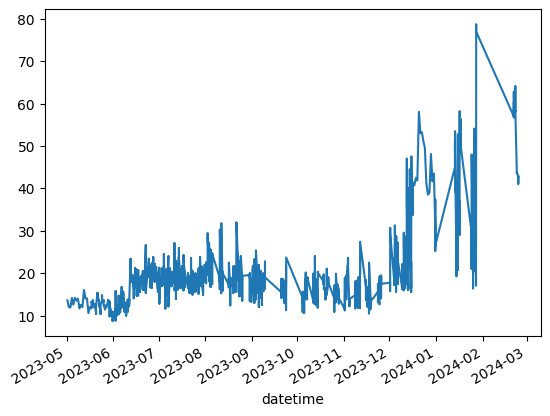

In [103]:
sub_df = pd.DataFrame()
sub_df["id"] = ids
sub_df["pm2_5"] = np.expm1(xgb_model.predict(X_test)) # np.mean(test_predictions, axis=0) # 
sub_df.to_csv("submission.csv", index=False)
sub_df["pm2_5"].plot()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

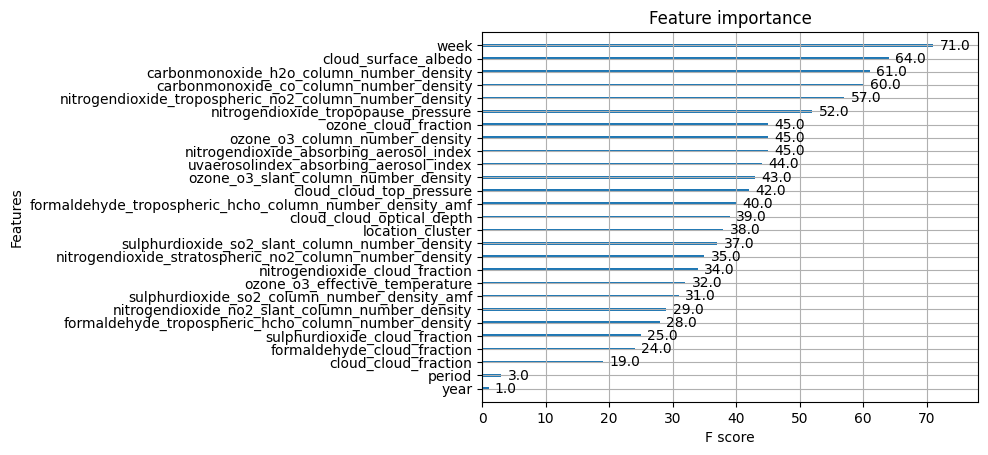

In [104]:
xgb.plot_importance(xgb_model)

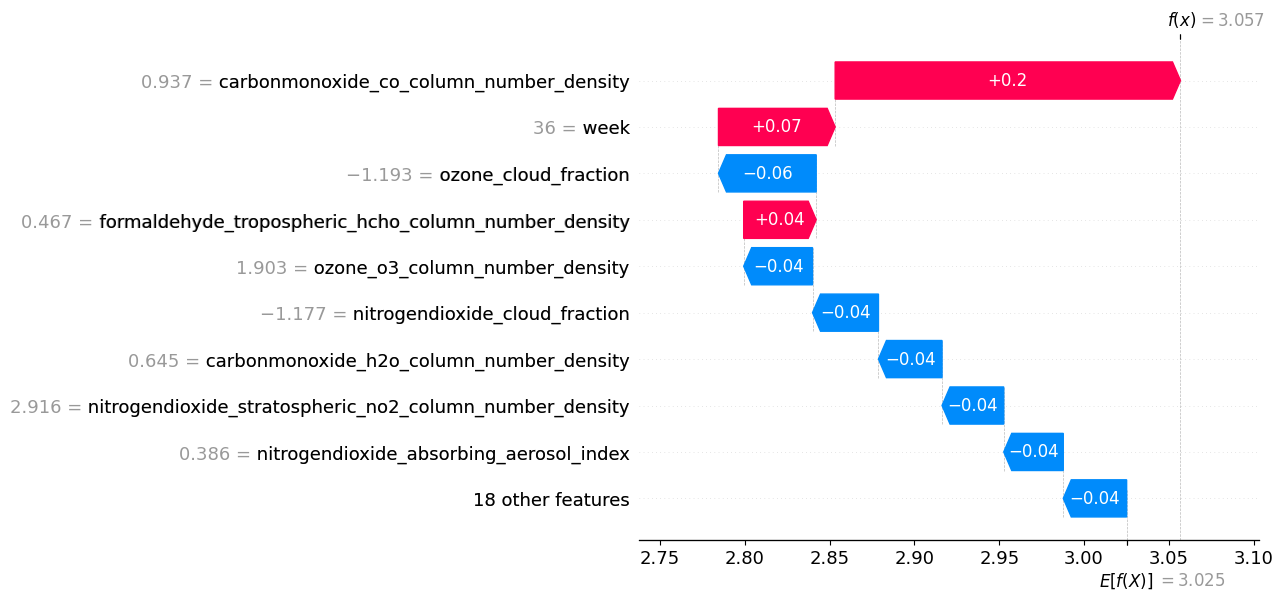

In [44]:
explainer = shap.Explainer(xgb_model)
# explain the model's predictions using SHAP
shap_values = explainer(X_test)
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

## Features pushing the model predictions higher are shown in red while those pushing the predictions lower are in blue.

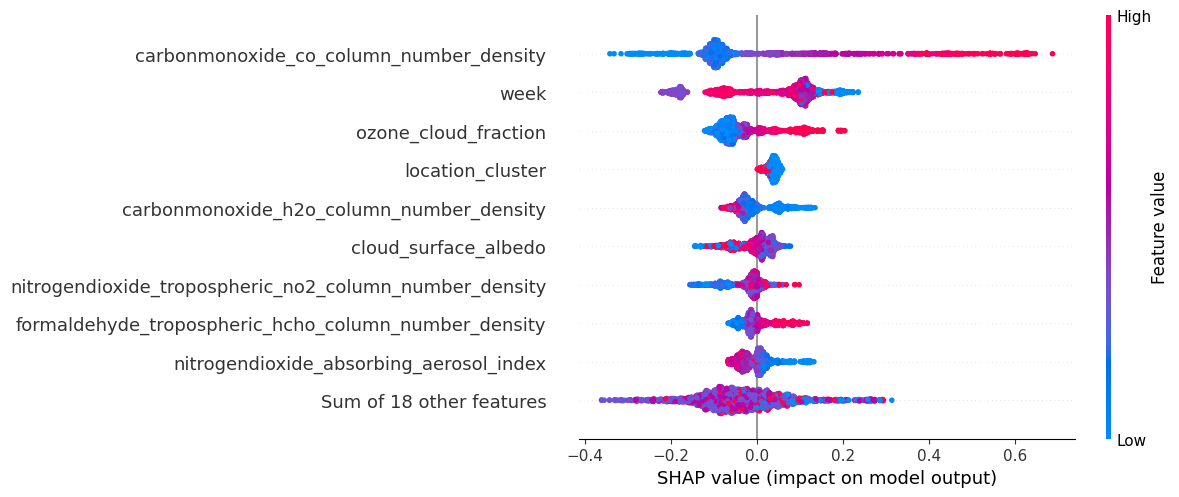

In [45]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [38]:
min(test_predictions[3]), max(test_predictions[3])

(9.120348, 84.10411)

## KAN

In [71]:
import torch
import torch.nn as nn

In [ ]:
class ChebyKANLayer(nn.Module):
  def __init__(self, input_dim, output_dim, degree):
    super(ChebyKANLayer, self).__init__()
    self.inputdim = input_dim
    self.outdim = output_dim
    self.degree = degree

    self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
    nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
    self.register_buffer("arange", torch.arange(0, degree + 1, 1))

  def forward(self, x):
    # Since Chebyshev polynomial is defined in [-1, 1]
    # We need to normalize x to [-1, 1] using tanh
    x = torch.tanh(x)
    # View and repeat input degree + 1 times
    x = x.view((-1, self.inputdim, 1)).expand(
        -1, -1, self.degree + 1
    )  # shape = (batch_size, inputdim, self.degree + 1)
    # Apply acos
    x = x.acos()
    # Multiply by arange [0 .. degree]
    x *= self.arange
    # Apply cos
    x = x.cos()
    # Compute the Chebyshev interpolation
    y = torch.einsum(
        "bid,iod->bo", x, self.cheby_coeffs
    )  # shape = (batch_size, outdim)
    y = y.view(-1, self.outdim)
    return y


class ChebyKAN(nn.Module):
  def __init__(self):
    super(ChebyKAN, self).__init__()
    self.chebykan1 = ChebyKANLayer(1, 10, 10)
    self.chebykan2 = ChebyKANLayer(10, 1, 10)

  def forward(self, x):
    x = self.chebykan1(x)
    x = self.chebykan2(x)
    return x

model = ChebyKAN()

In [ ]:
datasets = []

n_peak = 5
n_num_per_peak = 100
n_sample = n_peak * n_num_per_peak

x_grid = torch.linspace(-1,1,steps=n_sample)

x_centers = 2/n_peak * (np.arange(n_peak) - n_peak/2+0.5)

x_sample = torch.stack([torch.linspace(-1/n_peak,1/n_peak,steps=n_num_per_peak)+center for center in x_centers]).reshape(-1,)


y = 0.
for center in x_centers:
    y += torch.exp(-(x_grid-center)**2*300)

y_sample = 0.
for center in x_centers:
    y_sample += torch.exp(-(x_sample-center)**2*300)


plt.plot(x_grid.detach().numpy(), y.detach().numpy())
plt.scatter(x_sample.detach().numpy(), y_sample.detach().numpy())

In [ ]:
## Sequentially present different peaks to KAN
plt.subplots(1, 5, figsize=(15, 2))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(1,6):
    plt.subplot(1,5,i)
    group_id = i - 1
    plt.plot(x_grid.detach().numpy(), y.detach().numpy(), color='black', alpha=0.1)
    plt.scatter(x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak].detach().numpy(), color="black", s=2)
    plt.xlim(-1,1)
    plt.ylim(-1,2)

In [ ]:
ys = []

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 1000
for group_id in range(n_peak):
    train_data = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    train_label = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    test_data = x_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]
    test_label = y_sample[group_id*n_num_per_peak:(group_id+1)*n_num_per_peak][:,None]

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_label)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')


    y_pred = model(x_grid[:,None])
    ys.append(y_pred.detach().numpy()[:,0])

In [ ]:
auto x = torch::randn(128, dtype=kDouble);
auto n = torch::randn(128, dtype=kDouble);

torch::special::chebyshev_polynomial_v(x, n);

In [33]:
train_df.index.value_counts(), train_df.shape

(datetime
 2024-01-26 10:00:00    42
 2024-01-24 11:00:00    41
 2024-01-25 11:00:00    39
 2024-01-27 10:00:00    35
 2023-07-21 11:00:00    35
                        ..
 2023-12-26 13:00:00     1
 2023-12-25 12:00:00     1
 2023-12-24 12:00:00     1
 2023-12-23 13:00:00     1
 2023-11-08 12:00:00     1
 Name: count, Length: 437, dtype: int64,
 (8021, 26))

In [242]:
pm2_5 = TimeSeries.from_dataframe(train_df, value_cols=["pm2_5"], fill_missing_dates=True, freq="H").astype(np.float32) #2H/D frequencies
#feature_names = features.columns.tolist()[:-1]
#for f in features_names:
#s1 = TimeSeries.from_dataframe(df, value_cols=predictors[0]).astype(np.float32)
#s2 = TimeSeries.from_dataframe(df, value_cols=predictors[1]).astype(np.float32)
#s3 = TimeSeries.from_dataframe(df, value_cols=predictors[2]).astype(np.float32)
#s4 = TimeSeries.from_dataframe(df, value_cols=predictors[3]).astype(np.float32)
#s5 = TimeSeries.from_dataframe(df, value_cols=predictors[4]).astype(np.float32)
#temp = TimeSeries.from_dataframe(df, value_cols=predictors[5]).astype(np.float32)
#rh = TimeSeries.from_dataframe(df, value_cols=predictors[6]).astype(np.float32)

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# Split the dataset into training and validation sets for the current target
train_period = "390D"  # 390 days train, 31 days validation (421 days total in train dataset)
split_date = train_df.index.min() + pd.Timedelta(train_period) # train-val split date

X_train = train_df.loc[train_df.index <= split_date, feature_names]
y_train = train_df.loc[train_df.index <= split_date, "pm2_5"]
X_val = train_df.loc[train_df.index > split_date, feature_names]
y_val = train_df.loc[train_df.index > split_date, "pm2_5"]
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

target_scaler = Scaler()
target_scaled = target_scaler.fit_transform(pm2_5)

train_co, val_co = co_scaled[:-1000], co_scaled[-1000:]
# train_c6h6, val_c6h6 = c6h6_scaled[:-1000], c6h6_scaled[-1000:]
# train_nox, val_nox = nox_scaled[:-1000], nox_scaled[-1000:]
# train_no2, val_no2 = no2_scaled[:-1000], no2_scaled[-1000:]

train_co.plot()

## Experiment with transformer models for timeseries forecasting

* Apply an embedding layer to represent the time-features pairs and extrapolate from there